In [10]:
# import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from matplotlib.tri import Triangulation

from datautilities import MeshIO as io
from datautilities import meshmethods as mm


In [24]:
# Paths and meshes
nregion = 2
root_dir = Path(f"../Data/Region{nregion}LR4")

lr_mesh = io.load_mesh(root_dir / "LR8_mesh.pickle")
mesh = io.load_mesh(root_dir / "HR_mesh.pickle")

# Which low-resolution to load
lr_res = "LR8_raw_6cpu"
hr_res = "HR_6cpu"

# Choose the years to display
# years = [1959, 1960, 1961, 1962, 1963]
years = [1964]

In [25]:
# Load low- and high-resolution data
lr = mm.load_data("Hs", res=lr_res, years=years, root_dir=root_dir)

hr = mm.load_data("Hs", res=hr_res, years=years, root_dir=root_dir)

In [4]:
def compute_corr_map(arr1: np.ndarray, arr2: np.ndarray) -> np.ndarray:
    """Compute a correlation map for two spatial time series

    Parameters
    ----------
    arr1 : np.ndarray
        First spatial time series, has to be of shape (ntimes, nnodes)
    arr2 : np.ndarray
        Second spatial time series, has to be of shape (ntimes, nnodes)

    Returns
    -------
    np.ndarray
        Numpy array of shape (nnodes, ) with all the correlation coefficients
        per node
    """    
    nnodes = arr1.shape[-1]
    corr_map = np.zeros(nnodes)
    
    for idx in range(nnodes):
        loc1 = arr1[:, idx]
        loc2 = arr2[:, idx]

        # Exclude all nans for each node
        mask = (~np.isnan(loc1) & ~np.isnan(loc2))
        
        corr_map[idx] = np.corrcoef(loc1[mask], loc2[mask])[1, 0]
    
    return corr_map

In [5]:
def avg_corr_map(arr1: np.ndarray, arr2: np.ndarray) -> np.ndarray:
    """Compute a correlation map for two spatial time series

    Parameters
    ----------
    arr1 : np.ndarray
        First spatial time series, has to be of shape (ntimes, nnodeslr)
    arr2 : np.ndarray
        Second spatial time series, has to be of shape (ntimes, nnodeshr)

    Returns
    -------
    np.ndarray
        Numpy array of shape (nnodeshr, ) with all the correlation coefficients
        per node
    """    
    nnodeslr = arr1.shape[-1]
    nnodeshr = arr2.shape[-1]
    corr_map = np.zeros(nnodeshr)
    avg_corr = np.zeros(nnodeslr)
    
    for idx_hr in range(nnodeshr):
        hr = arr2[:, idx_hr]
        # Compute correlation for every lr node and take average
        for idx_lr in range(nnodeslr):
            lr = arr1[:, idx_lr]
            # Exclude all nans for each node
            mask = (~np.isnan(lr) & ~np.isnan(hr))
            avg_corr[idx_lr] = np.corrcoef(lr[mask], hr[mask])[1, 0]

        corr_map[idx_hr] = np.nanmean(avg_corr)
    
    return corr_map

In [6]:
def point_corr_map(arr1: np.ndarray, arr2: np.ndarray, pnt: int) -> np.ndarray:
    """Compute a correlation map for two spatial time series

    Parameters
    ----------
    arr1 : np.ndarray
        First spatial time series, has to be of shape (ntimes, nnodes)
    arr2 : np.ndarray
        Second spatial time series, has to be of shape (ntimes, nnodes)
    pnt : int
        Point of arr1 to choose for correlations

    Returns
    -------
    np.ndarray
        Numpy array of shape (nnodes, ) with all the correlation coefficients
        per node
    """    
    nnodes = arr2.shape[-1]
    corr_map = np.zeros(nnodes)
    
    for idx in range(nnodes):
        loc1 = arr1[:, pnt]
        loc2 = arr2[:, idx]

        # Exclude all nans for each node
        mask = (~np.isnan(loc1) | ~np.isnan(loc2))

        if (~mask).all():
            corr_map[idx] = np.nan
            continue

        corr_map[idx] = np.corrcoef(loc1[mask], loc2[mask])[1, 0]

    return corr_map

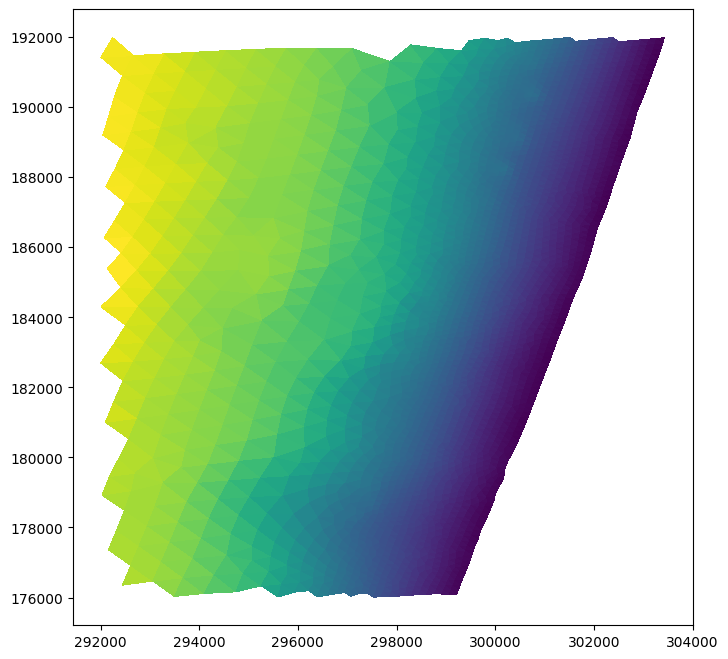

In [33]:
pnt = 75
# mm.plot_meshed_data(lr_mesh.values, lr_mesh)
mm.plot_meshed_data(mesh.values, mesh)
# plt.scatter(lr_mesh.coords[pnt, 0], lr_mesh.coords[pnt, 1], s = 50)

In [7]:
def plot_corr_map(
    corr_map: np.ndarray,
    mesh: io.MeshIO,
    save: bool = True,
    save_path: str | Path = Path("../plots/correlation-map.png"),
    figsize: tuple[int, int] = (6, 8),
    **kwargs
) -> tuple[mpl.figure.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=figsize)

    im = mm.plot_meshed_data(
        corr_map**2, mesh, vmin=0, vmax=1, ax=ax, **kwargs
        )
    
    plt.colorbar(im, label=r"$R^2$ correlation")
    
    if save:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=600, bbox_inches="tight")
    
    return fig, ax

## Correlation map: Diff - Diff-LR

In [26]:
corr_map = point_corr_map(lr, hr, 11)

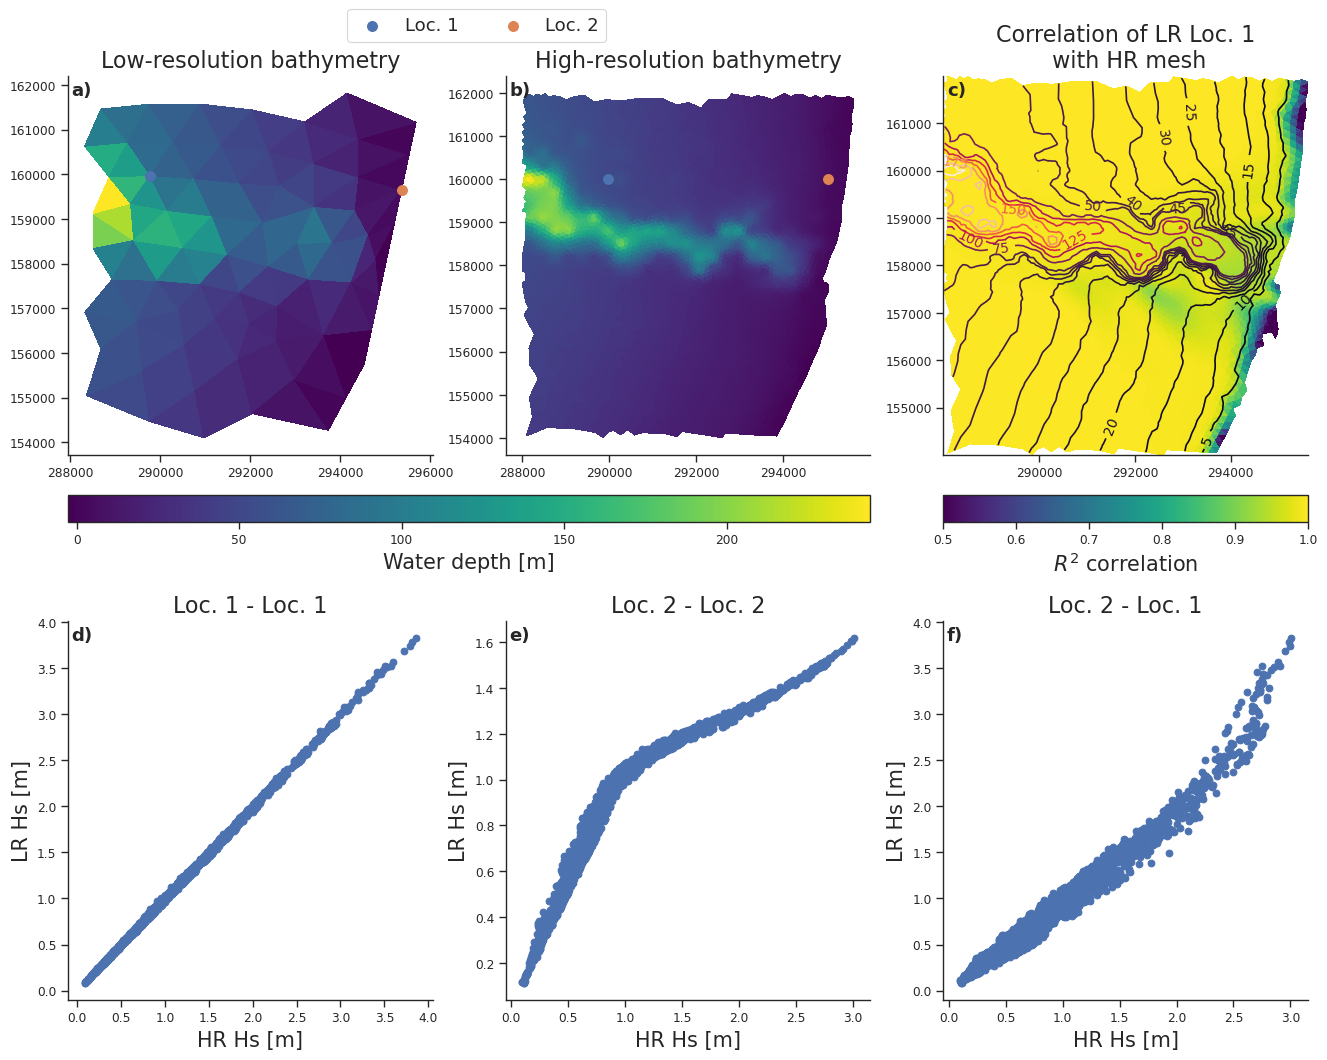

In [30]:
%matplotlib inline
# Define which points to plot
# Region 1
# lr_pnt1 = 11
# lr_pnt2 = 22
# hr_pnt1 = 566
# hr_pnt2 = 1933
# Region 2
lr_pnt1 = 17
lr_pnt2 = 66
hr_pnt1 = 1032
hr_pnt2 = 3669
# Region 3
# lr_pnt1 = 19
# lr_pnt2 = 78
# hr_pnt1 = 159
# hr_pnt2 = 1964

mosaic = [["lr", "hr", "corr"],
          ["cb_mesh", "cb_mesh", "cb_corr"],
          ["empty", "empty", "empty"],
          ["scatter1", "scatter2", "scatter3"]]

fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(16, 12),
                              height_ratios=[1, 0.07, 0.05, 1],
                              width_ratios=[1, 1, 1])
sns.set_theme(context="paper", style="ticks")
sns.despine()

plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 16

# Set empty line invisible
axs["empty"].set_visible(False)

# Plot meshes
mm.plot_meshed_data(lr_mesh.values, lr_mesh, ax=axs["lr"], cmap="viridis")
im1 = mm.plot_meshed_data(mesh.values, mesh, ax=axs["hr"], cmap="viridis")
im2 = mm.plot_meshed_data(corr_map**2, mesh, ax=axs["corr"], cmap="viridis",
                          vmin=0.5, vmax=1)

# Create contour plot
# levels = np.arange(5, mesh.values.max(), 5)
levels = np.r_[np.arange(5, 55, 5), np.arange(75, mesh.values.max(), 25)]
triangles = Triangulation(mesh.coords[:, 0], mesh.coords[:, 1], mesh.triangles-1)
cs = axs["corr"].tricontour(triangles, mesh.values, levels=levels)
axs["corr"].clabel(cs, inline=True, fontsize=10, fmt="%1.0f")

fig.colorbar(im1, cax=axs["cb_mesh"], label="Water depth [m]",
             orientation="horizontal")
fig.colorbar(im2, cax=axs["cb_corr"], label=r"$R^2$ correlation",
             orientation="horizontal")

axs["lr"].set_title("Low-resolution bathymetry")
axs["hr"].set_title("High-resolution bathymetry")
axs["corr"].set_title("Correlation of LR Loc. 1\n with HR mesh")

# Plot scatter points
axs["lr"].scatter(lr_mesh.coords[lr_pnt1, 0], lr_mesh.coords[lr_pnt1, 1], s=50,
                  label="Loc. 1")
axs["lr"].scatter(lr_mesh.coords[lr_pnt2, 0], lr_mesh.coords[lr_pnt2, 1], s=50,
                  label="Loc. 2")
axs["hr"].scatter(mesh.coords[hr_pnt1, 0], mesh.coords[hr_pnt1, 1], s=50)
axs["hr"].scatter(mesh.coords[hr_pnt2, 0], mesh.coords[hr_pnt2, 1], s=50)

axs["lr"].xaxis.set_major_locator(plt.MaxNLocator(5))
axs["hr"].xaxis.set_major_locator(plt.MaxNLocator(5))
axs["corr"].xaxis.set_major_locator(plt.MaxNLocator(5))


axs["lr"].legend(ncol=2, bbox_to_anchor=(1.5, 1.2), fontsize=13)

# Plot correlation plots
axs["scatter1"].scatter(hr[:, hr_pnt1], lr[:, lr_pnt1])
axs["scatter1"].set_title("Loc. 1 - Loc. 1")
axs["scatter1"].set_xlabel("HR Hs [m]")
axs["scatter1"].set_ylabel("LR Hs [m]")

axs["scatter2"].scatter(hr[:, hr_pnt2], lr[:, lr_pnt2])
axs["scatter2"].set_title("Loc. 2 - Loc. 2")
axs["scatter2"].set_xlabel("HR Hs [m]")
axs["scatter2"].set_ylabel("LR Hs [m]")

axs["scatter3"].scatter(hr[:, hr_pnt2], lr[:, lr_pnt1])
axs["scatter3"].set_title("Loc. 2 - Loc. 1")
axs["scatter3"].set_xlabel("HR Hs [m]")
axs["scatter3"].set_ylabel("LR Hs [m]")

# Panel relative location
x = 0.01
y = 0.95
# Add panel labels
plt.rcParams["font.size"] = 13
axs["lr"].text(x, y, "a)", transform=axs["lr"].transAxes, fontweight="bold")
axs["hr"].text(x, y, "b)", transform=axs["hr"].transAxes, fontweight="bold")
axs["corr"].text(x, y, "c)", transform=axs["corr"].transAxes, fontweight="bold")
axs["scatter1"].text(x, y, "d)", transform=axs["scatter1"].transAxes, fontweight="bold")
axs["scatter2"].text(x, y, "e)", transform=axs["scatter2"].transAxes, fontweight="bold")
axs["scatter3"].text(x, y, "f)", transform=axs["scatter3"].transAxes, fontweight="bold")

out_path = Path("plots") / f"region{nregion}" / f"correlation-map-region{nregion}"
out_path.parent.mkdir(exist_ok=True, parents=True)
plt.savefig(out_path, dpi=300, bbox_inches="tight")

In [29]:
# Select nodes closest to given location
# Region 1
# xy1 = np.array([282000, 142000])
# xy2 = np.array([286500, 142000])
# Region 2
xy1 = np.array([290000, 160000])
xy2 = np.array([295000, 160000])
# Region 3
# xy1 = np.array([295000, 184000])
# xy2 = np.array([300600, 184000])

print(mesh.get_closest_node_index(xy1))
print(lr_mesh.get_closest_node_index(xy1))

print(mesh.get_closest_node_index(xy2))
print(lr_mesh.get_closest_node_index(xy2))

1032
17
3669
66


# Wave height variance

In [43]:
lr1 = lr[:, 17]
hr1 = hr[:, 66]

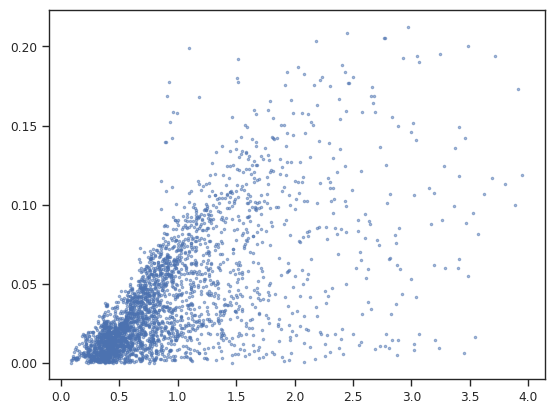

In [44]:
fig, ax = plt.subplots()

# mm.scatter_density(hr1, np.abs(lr1 - hr1), ax=ax)
ax.scatter(hr1, np.abs(lr1 - hr1), s=3, alpha=0.5)

# Correlation map (one lr against all hr)

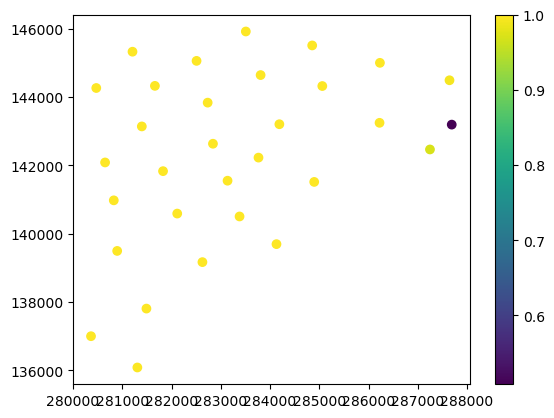

In [11]:
map1 = point_corr_map(lr, lr, lr_pnt1)

# plot_corr_map(map1, lr_mesh, figsize=(7, 6), save=False, save_path=Path("plots/region1/correlation-map"))
im = plt.scatter(lr_mesh.coords[:, 0], lr_mesh.coords[:, 1], c=map1)
plt.colorbar(im)
plt.show()

In [15]:
map1 > 0.95

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False, False,  True, False, False])

In [13]:
%matplotlib qt
lr_mesh.select_closest_node()

22

In [21]:
print(sum(hr[:, hr_pnt2]))
print(sum(lr[:, lr_pnt2]))

nan
nan


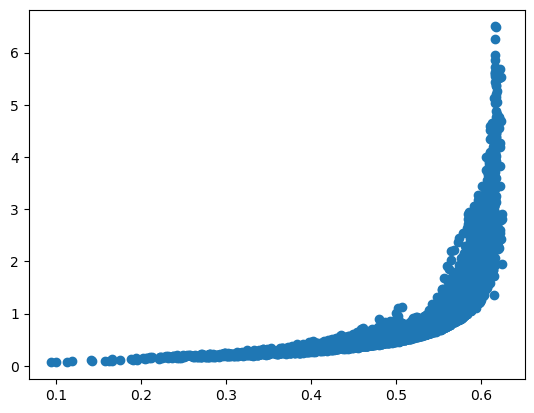

In [25]:
# plt.scatter(lr[:, lr_pnt], hr[:, pnt])
plt.scatter(hr[:, pnt], lr[:, lr_pnt])

## Correlation map: hr - diff

/home/jannik/anaconda3/envs/pytorch_mcia/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jannik/anaconda3/envs/pytorch_mcia/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(<Figure size 600x800 with 2 Axes>, <Axes: >)

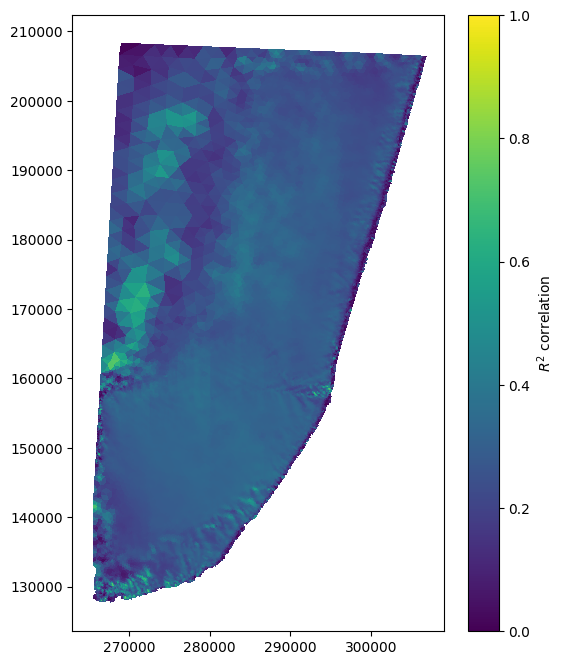

In [11]:
corr_map = compute_corr_map(diff_spatial, hr_spatial)
# TODO: Save image in a plots/correlation-map folder
plot_corr_map(corr_map, mesh, save=False)

## Correlation map: improvement - diff

In [ ]:
corr_map = compute_corr_map(diff_spatial, imp_spatial)
# TODO: Save image in a plots/correlation-map folder
plot_corr_map(corr_map, mesh, save=False)